In [3]:
import torch
import math
from torch import nn
import torch.nn.functional as F

In [4]:

class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


In [5]:
## get the scaled dot product attention values
class ScaledDotProduct(nn.Module):
  def __init__(self):
    super(ScaledDotProduct, self).__init__()
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, q, k, v, mask, dropout: nn.Dropout):
    d_k = q.shape[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2) / math.sqrt(d_k)) # 30,8, 200, 200
    if mask is not None:
        scaled.masked_fill_(mask == 0, -1e9)

    attention = self.softmax(scaled) # 30, 200, 64
    if dropout is not None:
        attention = dropout(attention)
    values = torch.matmul(attention, v)
    return values, attention

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Extract parameters from config
        self.d_model = config["hidden_size"]
        self.h = config["num_attention_heads"]
        assert self.d_model % self.h == 0, "d_model must be divisible by h"
        self.d_k = self.d_model // self.h
        bias = config["qkv_bias"]

        # Initialize projection layers
        self.w_q = nn.Linear(self.d_model, self.d_model, bias=bias)
        self.w_k = nn.Linear(self.d_model, self.d_model, bias=bias)
        self.w_v = nn.Linear(self.d_model, self.d_model, bias=bias)
        self.w_o = nn.Linear(self.d_model, self.d_model, bias=bias)

        # Initialize attention mechanism (assumed to be defined elsewhere)
        self.attention = ScaledDotProduct()

        # Initialize dropout layers
        self.attention_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Self-attention: q = k = v = x
        q = k = v = x
        mask = None  # No mask, as per ViT implementation

        # Project inputs
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # Reshape and transpose for multi-head attention
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Compute attention
        x, attention_scores = self.attention(query, key, value, mask, self.attention_dropout)

        # Reshape output
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Apply output projection and dropout
        output = self.w_o(x)
        output = self.output_dropout(output)

        # Return outputs
        return (output, attention_scores if output_attentions else None)

In [8]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta
        print(f"self.gamma: {self.gamma.size()}, self.beta: {self.beta.size()}")
        print(f"out: {out.size()}")
        return out

In [9]:
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

In [10]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


In [11]:

class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        # self.use_faster_attention = config.get("use_faster_attention", False)
        # if self.use_faster_attention:
        #     self.attention = FasterMultiHeadAttention(config)
        # else:
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

In [12]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [19]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


In [14]:

class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [15]:
class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [16]:
#@title Prepare Data 📊
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return trainloader, testloader, classes

In [17]:
#@title Utils 🛠️
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(experiment_name, config, model, train_losses, test_losses, accuracies, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    # Save the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'w') as f:
        json.dump(config, f, sort_keys=True, indent=4)

    # Save the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'w') as f:
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'accuracies': accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    # Save the model
    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f'model_{epoch}.pt')
    torch.save(model.state_dict(), cpfile)


def load_experiment(experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    # Load the config
    configfile = os.path.join(outdir, 'config.json')
    with open(configfile, 'r') as f:
        config = json.load(f)
    # Load the metrics
    jsonfile = os.path.join(outdir, 'metrics.json')
    with open(jsonfile, 'r') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    test_losses = data['test_losses']
    accuracies = data['accuracies']
    # Load the model
    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images.
    """
    model.eval()
    # Load random images
    num_images = 30
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    # Pick 30 samples randomly
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]
    # Convert the images to tensors
    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    images = torch.stack([test_transform(image) for image in raw_images])
    # Move the images to the device
    images = images.to(device)
    model = model.to(device)
    # Get the attention maps from the last block
    logits, attention_maps = model(images, output_attentions=True)
    # Get the predictions
    predictions = torch.argmax(logits, dim=1)
    # Concatenate the attention maps from all blocks
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_maps = attention_maps[:, :, 0, 1:]
    # Then average the attention maps of the CLS token over all the heads
    attention_maps = attention_maps.mean(dim=1)
    # Reshape the attention maps to a square
    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)
    # Resize the map to the size of the image
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(32, 32), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    # Plot the images and the attention maps
    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)
        # Mask out the attention map of the left image
        extended_attention_map = np.concatenate((np.zeros((32, 32)), attention_maps[i].cpu()), axis=1)
        extended_attention_map = np.ma.masked_where(mask==1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap='jet')
        # Show the ground truth and the prediction
        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(f"gt: {gt} / pred: {pred}", color=("green" if gt==pred else "red"))
    if output is not None:
        plt.savefig(output)
    plt.show()

In [20]:
#@title Train ViT 🧠 🏋🏽
#@title String fields

exp_name = 'vit-with-10-epochs' #@param {type:"string"}
batch_size = 32 #@param {type: "integer"}
epochs = 5 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input zaimage size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    The simple trainer.
    """

    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        """
        Train the model for the specified number of epochs.
        """
        # Keep track of the losses and accuracies
        train_losses, test_losses, accuracies = [], [], []
        # Train the model
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.exp_name, self.model, i+1)
        # Save the experiment
        save_experiment(self.exp_name, config, self.model, train_losses, test_losses, accuracies)

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            # Move the batch to the device
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            # Zero the gradients
            self.optimizer.zero_grad()
            # Calculate the loss
            loss = self.loss_fn(self.model(images)[0], labels)
            # Backpropagate the loss
            loss.backward()
            # Update the model's parameters
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits, _ = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    # Training parameters
    save_model_every_n_epochs = save_model_every
    # Load the CIFAR10 dataset
    trainloader, testloader, _ = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every_n_epochs)


if __name__ == '__main__':
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train loss: 1.8111, Test loss: 1.5709, Accuracy: 0.4276
Epoch: 2, Train loss: 1.5206, Test loss: 1.4429, Accuracy: 0.4796
Epoch: 3, Train loss: 1.4441, Test loss: 1.4439, Accuracy: 0.4737
Epoch: 4, Train loss: 1.3833, Test loss: 1.3828, Accuracy: 0.5042
Epoch: 5, Train loss: 1.3514, Test loss: 1.2904, Accuracy: 0.5303


In [30]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00


Files already downloaded and verified


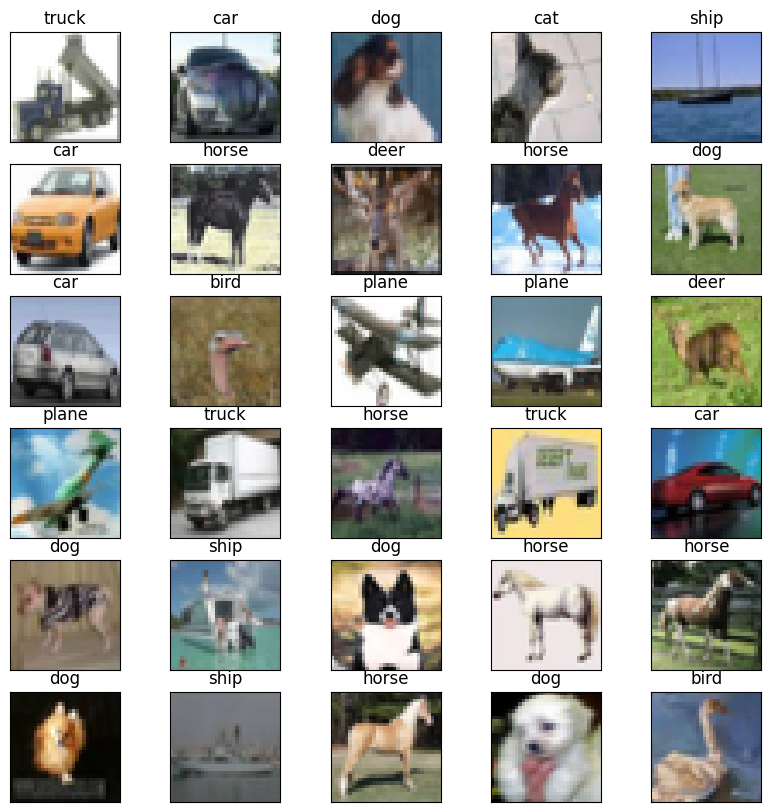

In [21]:
visualize_images()

<ipython-input-17-458959849c81>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cpfile))


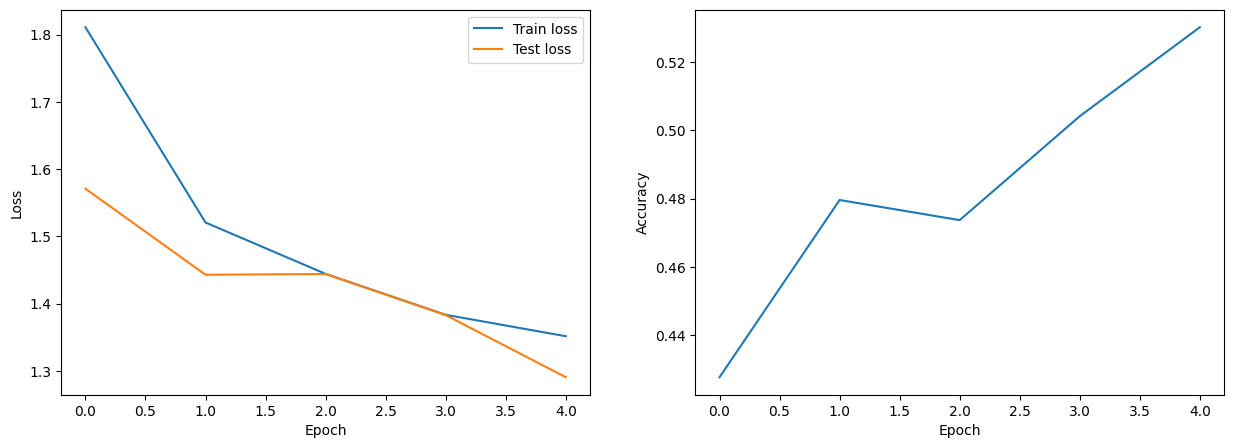

In [22]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"/content/experiments/{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


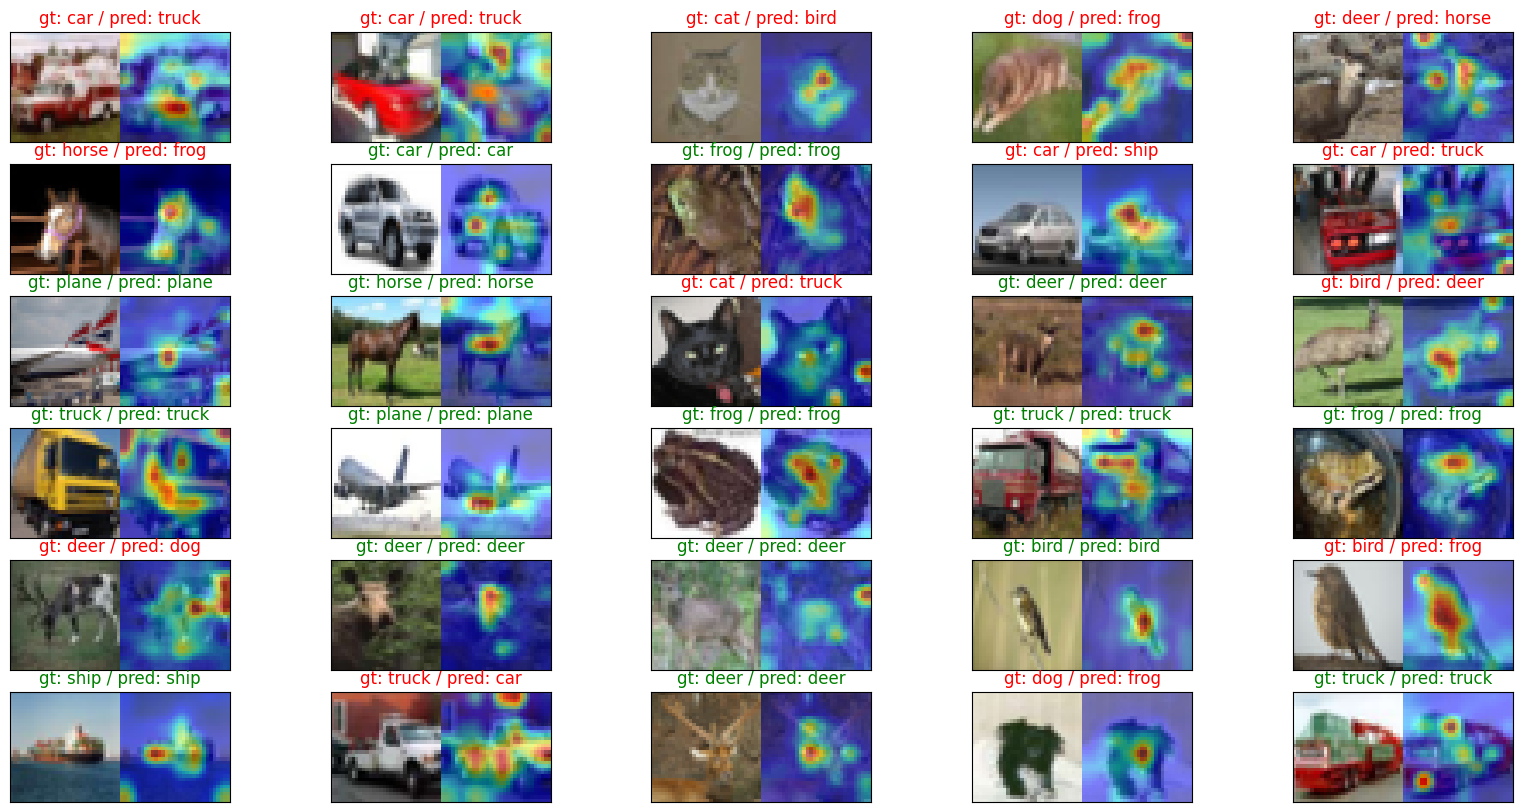

In [23]:
visualize_attention(model, "attention.png")

In [26]:
!pip install torchinfo

In [27]:
from torchinfo import summary

In [28]:
summary(model, (1,3,32,32))

Layer (type:depth-idx)                             Output Shape              Param #
ViTForClassfication                                [1, 10]                   --
├─Embeddings: 1-1                                  [1, 65, 48]               3,168
│    └─PatchEmbeddings: 2-1                        [1, 64, 48]               --
│    │    └─Conv2d: 3-1                            [1, 48, 8, 8]             2,352
│    └─Dropout: 2-2                                [1, 65, 48]               --
├─Encoder: 1-2                                     [1, 65, 48]               --
│    └─ModuleList: 2-3                             --                        --
│    │    └─Block: 3-2                             [1, 65, 48]               28,272
│    │    └─Block: 3-3                             [1, 65, 48]               28,272
│    │    └─Block: 3-4                             [1, 65, 48]               28,272
│    │    └─Block: 3-5                             [1, 65, 48]               28,272
├─Linear: 1-3